In [1]:
import numpy as np
import pandas as pd
import random
%matplotlib inline
import matplotlib.pyplot as plt
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from sklearn.model_selection import cross_val_score

In [2]:
hate_data = pd.read_csv("hate_speech_binary_dataset.csv", delimiter=",") # 혐오 문장
genderbias_data = pd.read_csv('genderbias.csv', sep=',')  # 여성 비하 문장
ilbe_data = pd.read_csv('badword.csv',encoding='CP949') # 일베 문장

## 문장 전처리

In [3]:
# 혐오 문장 처리
hate_data.columns = ['comment', 'label'] # 컬럼 명 변경
hate_data = hate_data.astype({'comment': 'str'})
hate_data = hate_data[hate_data['label']==1]

In [4]:
# 여성 비하 문장 처리
del genderbias_data['bias']    #해당 데이터셋의 필요없는 열 제거
del genderbias_data['hate']    #해당 데이터셋의 필요없는 열 제거
genderbias_data['contain_gender_bias'] = genderbias_data['contain_gender_bias'].replace([False, True],[0,1])  # 구분하기 쉽게 기존의 표기를 0,1로 변경
# genderbias_data = genderbias_data[['contain_gender_bias', 'comments']]    #구분하기 쉽게 열의 순서를 변경

genderbias_data.columns = ['comment', 'label'] # 컬럼 명 변경
genderbias_data = genderbias_data[genderbias_data['label']==1]

In [5]:
# 일베 문장 처리
ilbe_data = ilbe_data[['v2', 'v1']]    #구분하기 쉽게 열의 순서를 변경
ilbe_data.columns = ['comment', 'label'] # 컬럼 명 변경
ilbe_data = ilbe_data[ilbe_data['label']==1]

In [6]:
# 데이터 개수
print("hate_data : %d" % len(hate_data))
print("genderbias_data : %d" % len(genderbias_data))
print("ilbe_data : %d" % len(ilbe_data))

hate_data : 100000
genderbias_data : 1232
ilbe_data : 2044


## 라벨링 및 합치기

In [7]:
# 렌덤하게 문장 추출 후 라벨링 거치는 함수
def random_labeling(data, classified_data, label_num, str_num):  # label_num : 라벨링 시킬 값, str_num 추출할 문장 개수
    random_data = classified_data.sample(n=str_num) # str_num 개의 행(문장) 랜덤 추출
    random_data.loc[random_data.label == 1, 'label'] = label_num # label_num으로 값 변경
    data = data.append(random_data)  # data 에 랜덤 추출된 데이터 추가
    return data

In [8]:
data_declaration = {
    'comment' : ["str_Declaration"],
    'label':[-1]
}


data = pd.DataFrame(data_declaration)
data

,comment,label
0,str_Declaration,-1


In [9]:
# 문장 개수를 모두 2000 개로 지정 각 
# 라벨은 혐오:0, 여성비하: 1, 일베: 2로 지정됨
data = random_labeling(data, hate_data, 0, 2000)
data = random_labeling(data, genderbias_data, 1, 1232)
data = random_labeling(data, ilbe_data, 2, 2044)

In [10]:
# 첫번째 행 제거
data = data.drop(0)

In [11]:
# 랜덤하게 섞기 
data = data.sample(frac=1).reset_index(drop=True)

In [12]:
print(type(data))

<class 'pandas.core.frame.DataFrame'>


## 중복 및 null 처리

In [13]:
def detect_overlap(data):
    exist_overlap = len(data)  # 데이터 전체 개수
    no_overlap = data['comment'].nunique()  # 중복 제거된 개수
    if exist_overlap != no_overlap:
        data.drop_duplicates(subset=['comment'], inplace=True)

In [14]:
detect_overlap(data)

In [15]:
# null 값 확인
data.isnull().values.any()

False

## 토큰화

In [16]:
def tokenize(x_data, tokenizer):
    tokenizer.fit_on_texts(x_data) # 데이터의 각 행별로 토큰화 수행
    return tokenizer.texts_to_sequences(x_data)    

In [17]:
x_data = data['comment']
y_data = data['label']

In [18]:
tokenizer = Tokenizer()
sequences = tokenize(x_data, tokenizer)

sequences

[[4772, 109, 4773, 2314, 4774, 7, 2315, 681, 2316, 4775, 62, 2317, 4776, 89],
 [38, 85, 2318, 18, 2319, 4777, 1073, 4778],
 [4779, 4780, 4781],
 [865, 2320, 4782, 4783, 10, 4784, 866, 1502, 4785, 4786],
 [17, 4787, 2321, 4788, 111],
 [2322, 4789, 1503, 4790, 205, 4791, 4792, 4793, 4794, 682, 3],
 [683, 446, 447, 82, 4, 2323, 56],
 [4795, 4796, 4797, 4798, 9, 367, 4799, 4800, 83],
 [4801, 148],
 [4802,
  4803,
  1504,
  1074,
  1505,
  4804,
  206,
  4805,
  684,
  291,
  4806,
  4807,
  4,
  2324,
  4808,
  4809,
  1506,
  448,
  2325,
  4810,
  16,
  4811,
  4812,
  1507,
  2325,
  4813,
  4814,
  4815,
  4816,
  4817,
  4818,
  1075,
  4819,
  4820,
  2326,
  4821,
  10,
  867,
  4822,
  368,
  4823,
  685,
  4824,
  128,
  868,
  4825,
  33,
  117,
  4826,
  4827,
  4828,
  4829,
  10,
  4830],
 [149, 1076, 129, 686, 2327, 8],
 [4831, 1508, 4832, 4833, 62, 1509, 4834, 4835, 4836, 4837, 4838, 4839, 4840],
 [28, 118, 37, 1],
 [4841, 505, 1510, 175, 4842, 4843],
 [4844, 4845, 4846, 484

## 희귀단어 확인

In [19]:
def detect_rareword(tokenizer, threshold):
    word_to_index = tokenizer.word_index 
    total_cnt = len(word_to_index) # 단어의 수
    rare_cnt = 0 # 등장 빈도수가 threshold보다 작은 단어의 개수를 카운트
    total_freq = 0 # 훈련 데이터의 전체 단어 빈도수 총 합
    rare_freq = 0 # 등장 빈도수가 threshold보다 작은 단어의 등장 빈도수의 총 합

    # 단어와 빈도수의 쌍(pair)을 key와 value로 받는다.
    for key, value in tokenizer.word_counts.items():
        total_freq = total_freq + value

        # 단어의 등장 빈도수가 threshold보다 작으면
        if(value < threshold):
            rare_cnt = rare_cnt + 1
            rare_freq = rare_freq + value

    print('등장 빈도가 %s번 이하인 희귀 단어의 수: %s'%(threshold - 1, rare_cnt))
    print("단어 집합(vocabulary)에서 희귀 단어의 비율:", (rare_cnt / total_cnt)*100)
    print("전체 등장 빈도에서 희귀 단어 등장 빈도 비율:", (rare_freq / total_freq)*100)
    

In [20]:
# 희귀 단어 확인
detect_rareword(tokenizer, 2)

등장 빈도가 1번 이하인 희귀 단어의 수: 23632
단어 집합(vocabulary)에서 희귀 단어의 비율: 83.20247861141429
전체 등장 빈도에서 희귀 단어 등장 빈도 비율: 48.74788563884649


## 훈련 데이터, 테스트 데이터 분리

In [21]:
# 가장 긴 길이
def max_length(X_data):
    return max(len(l) for l in X_data)

# 훈련 학습 데이터 개수
def num_dataset(raio, X_data):
    num_train = int(len(X_data)*0.8)
    num_test = int(len(X_data) - num_train)
    return num_train, num_test

# 훈련 및 학습 데이터 분리
def config_dataset(num_train, data, y_data):
    X_test = data[num_train:] #X_data 데이터 중에서 뒤의 개의 데이터만 저장
    y_test = np.array(y_data[num_train:]) #y_data 데이터 중에서 뒤의 개의 데이터만 저장
    X_train = data[:num_train] #X_data 데이터 중에서 앞의 n_of_train개의 데이터만 저장
    y_train = np.array(y_data[:num_train]) #y_data 데이터 중에서 앞의 n_of_train개의 데이터만 저장
    
    return X_test, y_test, X_train, y_train

In [22]:
# 최대 길이 계산
X_data = sequences
maxlen = max_length(X_data)

X_data

[[4772, 109, 4773, 2314, 4774, 7, 2315, 681, 2316, 4775, 62, 2317, 4776, 89],
 [38, 85, 2318, 18, 2319, 4777, 1073, 4778],
 [4779, 4780, 4781],
 [865, 2320, 4782, 4783, 10, 4784, 866, 1502, 4785, 4786],
 [17, 4787, 2321, 4788, 111],
 [2322, 4789, 1503, 4790, 205, 4791, 4792, 4793, 4794, 682, 3],
 [683, 446, 447, 82, 4, 2323, 56],
 [4795, 4796, 4797, 4798, 9, 367, 4799, 4800, 83],
 [4801, 148],
 [4802,
  4803,
  1504,
  1074,
  1505,
  4804,
  206,
  4805,
  684,
  291,
  4806,
  4807,
  4,
  2324,
  4808,
  4809,
  1506,
  448,
  2325,
  4810,
  16,
  4811,
  4812,
  1507,
  2325,
  4813,
  4814,
  4815,
  4816,
  4817,
  4818,
  1075,
  4819,
  4820,
  2326,
  4821,
  10,
  867,
  4822,
  368,
  4823,
  685,
  4824,
  128,
  868,
  4825,
  33,
  117,
  4826,
  4827,
  4828,
  4829,
  10,
  4830],
 [149, 1076, 129, 686, 2327, 8],
 [4831, 1508, 4832, 4833, 62, 1509, 4834, 4835, 4836, 4837, 4838, 4839, 4840],
 [28, 118, 37, 1],
 [4841, 505, 1510, 175, 4842, 4843],
 [4844, 4845, 4846, 484

In [23]:
Y_data = np.array(y_data)

## 문장 길이 분포 확인

문장 최대 길이 : 194
문장 평균 길이 : 9.209347


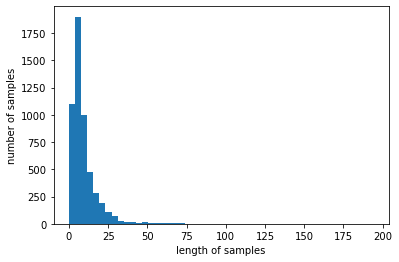

In [24]:
print('문장 최대 길이 : %d' % max(len(l) for l in X_data))
print('문장 평균 길이 : %f' % (sum(map(len, X_data))/len(X_data)))
plt.hist([len(s) for s in X_data], bins=50)
plt.xlabel('length of samples')
plt.ylabel('number of samples')
plt.show()

## 훈련 데이터, 학습 데이터 분할

In [25]:
# 훈련 및 학습 데이터 개수 비율 지정
numtrain, numtest = num_dataset(0.8, X_data)

x_data = pad_sequences(X_data, maxlen = maxlen)
x_data

array([[    0,     0,     0, ...,  2317,  4776,    89],
       [    0,     0,     0, ...,  4777,  1073,  4778],
       [    0,     0,     0, ...,  4779,  4780,  4781],
       ...,
       [    0,     0,     0, ..., 28397,  3683, 28398],
       [    0,     0,     0, ...,    10,  4166,   278],
       [    0,     0,     0, ..., 28402, 28403,  1136]])

In [26]:
X_test, y_test, X_train, y_train = config_dataset(numtrain, x_data, y_data)

y_test

array([2, 2, 2, ..., 2, 2, 0], dtype=int64)

# 학습 과정

In [27]:
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras import datasets
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, Dropout, Conv1D, GlobalMaxPooling1D, Dense
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
from tensorflow.keras.losses import SparseCategoricalCrossentropy
import pandas as pd
import tensorflow.keras.metrics 
from keras import backend as K
from sklearn.model_selection import KFold

In [28]:
def recall(y_true, y_pred):
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    possible_positives = K.sum(K.round(K.clip(y_true, 0, 1)))
    recall = true_positives / (possible_positives + K.epsilon())
    return recall

def precision(y_true, y_pred):
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    predicted_positives = K.sum(K.round(K.clip(y_pred, 0, 1)))
    precision = true_positives / (predicted_positives + K.epsilon())
    return precision

def f1(y_true, y_pred):
    precision_v = precision(y_true, y_pred)
    recall_v = recall(y_true, y_pred)
    return 2*((precision_v*recall_v)/(precision_v+recall_v+K.epsilon()))

## 검증 (K-fold)

In [29]:
size = 1000000

kfold = KFold(n_splits= 5, shuffle = True)

for train, test in kfold.split(X_train, y_train):
    model = Sequential()
    model.add(Embedding(size , 64, input_length = maxlen)) #워드 임베딩
    model.add(Dropout(0.5)) #과적합 방지를 위해 일부 Drop, 기본 50% 정도를 Drop하도록 설정함.
    model.add(Conv1D(64, 3, padding='valid', activation='relu')) #hidden layer 추가
    model.add(GlobalMaxPooling1D())
    model.add(Dropout(0.5)) #과적합 방지를 위해 일부 Drop, 기본 50% 정도를 Drop하도록 설정함.
    model.add(Dense(128, activation='relu'))
    model.add(Dropout(0.5)) #과적합 방지를 위해 일부 Drop, 기본 50% 정도를 Drop하도록 설정함.
    num_of_class = 3 #클래스는 우선 4개로 분류함(3+Unknown)
    model.add(Dense(num_of_class, activation='linear'))
    model.summary()
    
    model.compile(optimizer='adam', loss=SparseCategoricalCrossentropy(from_logits=True),metrics= ["accuracy",f1,precision, recall])
    es = EarlyStopping(monitor='loss', mode='min' , min_delta=0)
    check_point = ModelCheckpoint('best_model.h5', monitor='loss', mode='min', save_best_only=True)
    
    hist = model.fit(X_train, y_train, batch_size = 32, epochs=5, callbacks=[es, check_point])

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding (Embedding)        (None, 194, 64)           64000000  
_________________________________________________________________
dropout (Dropout)            (None, 194, 64)           0         
_________________________________________________________________
conv1d (Conv1D)              (None, 192, 64)           12352     
_________________________________________________________________
global_max_pooling1d (Global (None, 64)                0         
_________________________________________________________________
dropout_1 (Dropout)          (None, 64)                0         
_________________________________________________________________
dense (Dense)                (None, 128)               8320      
_________________________________________________________________
dropout_2 (Dropout)          (None, 128)               0

132/132 [==============================] - 157s 1s/step - loss: 1.0712 - accuracy: 0.3970 - f1: 0.7100 - precision: 33056866.1410 - recall: 0.3698
Epoch 3/5
132/132 [==============================] - 150s 1s/step - loss: 0.9226 - accuracy: 0.5730 - f1: 0.7370 - precision: 516823.9281 - recall: 0.5326
Epoch 4/5
132/132 [==============================] - 158s 1s/step - loss: 0.5062 - accuracy: 0.7965 - f1: 0.9383 - precision: 0.7601 - recall: 1.2600
Epoch 5/5
132/132 [==============================] - 144s 1s/step - loss: 0.2471 - accuracy: 0.9196 - f1: 0.9327 - precision: 0.7184 - recall: 1.3416
Model: "sequential_4"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_4 (Embedding)      (None, 194, 64)           64000000  
_________________________________________________________________
dropout_12 (Dropout)         (None, 194, 64)           0         
______________________________________________

## 학습

In [30]:
hist = model.fit(X_train, y_train, batch_size = 32, epochs=5, callbacks=[es, check_point])

Epoch 1/5
132/132 [==============================] - 144s 1s/step - loss: 0.1066 - accuracy: 0.9687 - f1: 0.9156 - precision: 0.7012 - recall: 1.3338
Epoch 2/5
132/132 [==============================] - 142s 1s/step - loss: 0.0485 - accuracy: 0.9872 - f1: 0.8588 - precision: 0.6729 - recall: 1.1993
Epoch 3/5
132/132 [==============================] - 143s 1s/step - loss: 0.0338 - accuracy: 0.9912 - f1: 0.8343 - precision: 0.6587 - recall: 1.1565
Epoch 4/5
132/132 [==============================] - 155s 1s/step - loss: 0.0232 - accuracy: 0.9950 - f1: 0.8155 - precision: 0.6488 - recall: 1.1121
Epoch 5/5
132/132 [==============================] - 144s 1s/step - loss: 0.0138 - accuracy: 0.9964 - f1: 0.8089 - precision: 0.6443 - recall: 1.1004


In [31]:
model2 = Sequential()
model2.add(Dense(num_of_class, activation = 'softmax'))
model2.compile(optimizer='adam', loss='sparse_categorical_crossentropy',metrics= ["accuracy"])

## Training

In [32]:
X_result = model.predict(X_test, batch_size = 32)
len(X_result)

1053

# OpenMax

In [33]:
class_result = []
for a,b,c in X_result:
    numbers = [a,b,c]
    class_result.append(numbers.index(max(numbers)))
    
class_result

[2,
 1,
 2,
 1,
 0,
 0,
 2,
 0,
 0,
 0,
 2,
 2,
 0,
 0,
 2,
 2,
 0,
 2,
 1,
 2,
 2,
 2,
 2,
 0,
 0,
 0,
 0,
 2,
 2,
 0,
 0,
 2,
 2,
 0,
 2,
 2,
 0,
 0,
 2,
 0,
 0,
 0,
 0,
 2,
 2,
 0,
 2,
 0,
 0,
 2,
 1,
 1,
 1,
 0,
 0,
 0,
 2,
 0,
 1,
 2,
 1,
 0,
 2,
 2,
 1,
 2,
 0,
 0,
 0,
 1,
 2,
 0,
 0,
 0,
 0,
 0,
 2,
 1,
 0,
 2,
 2,
 2,
 2,
 0,
 0,
 0,
 0,
 1,
 0,
 0,
 1,
 0,
 0,
 2,
 2,
 2,
 2,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 2,
 0,
 0,
 0,
 2,
 2,
 2,
 2,
 0,
 1,
 2,
 2,
 0,
 1,
 0,
 1,
 2,
 1,
 0,
 0,
 0,
 2,
 2,
 2,
 1,
 2,
 0,
 0,
 0,
 0,
 0,
 2,
 1,
 0,
 0,
 1,
 0,
 2,
 0,
 0,
 2,
 2,
 2,
 2,
 1,
 0,
 0,
 0,
 1,
 2,
 0,
 1,
 2,
 0,
 1,
 0,
 0,
 0,
 1,
 0,
 1,
 2,
 1,
 2,
 2,
 2,
 0,
 2,
 2,
 0,
 2,
 0,
 2,
 0,
 2,
 0,
 0,
 0,
 0,
 1,
 0,
 0,
 2,
 2,
 0,
 0,
 1,
 2,
 0,
 1,
 0,
 2,
 2,
 2,
 0,
 0,
 0,
 0,
 1,
 2,
 2,
 2,
 1,
 2,
 2,
 0,
 1,
 1,
 0,
 1,
 2,
 0,
 0,
 0,
 2,
 0,
 0,
 0,
 2,
 0,
 1,
 2,
 0,
 0,
 0,
 0,
 1,
 2,
 2,
 1,
 2,
 1,
 1,
 0,
 0,
 0,
 2,
 2,
 1,
 1,
 1,
 1,
 0,
 2,
 0,
 2,


In [34]:
tf_result = (y_test == class_result)

for_open_max_0 = [] 
for_open_max_1 = []
for_open_max_2 = []

for i in range(len(class_result)):
    if(tf_result[i] == True):
        if(class_result[i] == 0):
            for_open_max_0.append(X_result[i])
        if(class_result[i] == 1):
            for_open_max_1.append(X_result[i])
        if(class_result[i] == 2):
            for_open_max_2.append(X_result[i])

In [35]:
class_result

[2,
 1,
 2,
 1,
 0,
 0,
 2,
 0,
 0,
 0,
 2,
 2,
 0,
 0,
 2,
 2,
 0,
 2,
 1,
 2,
 2,
 2,
 2,
 0,
 0,
 0,
 0,
 2,
 2,
 0,
 0,
 2,
 2,
 0,
 2,
 2,
 0,
 0,
 2,
 0,
 0,
 0,
 0,
 2,
 2,
 0,
 2,
 0,
 0,
 2,
 1,
 1,
 1,
 0,
 0,
 0,
 2,
 0,
 1,
 2,
 1,
 0,
 2,
 2,
 1,
 2,
 0,
 0,
 0,
 1,
 2,
 0,
 0,
 0,
 0,
 0,
 2,
 1,
 0,
 2,
 2,
 2,
 2,
 0,
 0,
 0,
 0,
 1,
 0,
 0,
 1,
 0,
 0,
 2,
 2,
 2,
 2,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 2,
 0,
 0,
 0,
 2,
 2,
 2,
 2,
 0,
 1,
 2,
 2,
 0,
 1,
 0,
 1,
 2,
 1,
 0,
 0,
 0,
 2,
 2,
 2,
 1,
 2,
 0,
 0,
 0,
 0,
 0,
 2,
 1,
 0,
 0,
 1,
 0,
 2,
 0,
 0,
 2,
 2,
 2,
 2,
 1,
 0,
 0,
 0,
 1,
 2,
 0,
 1,
 2,
 0,
 1,
 0,
 0,
 0,
 1,
 0,
 1,
 2,
 1,
 2,
 2,
 2,
 0,
 2,
 2,
 0,
 2,
 0,
 2,
 0,
 2,
 0,
 0,
 0,
 0,
 1,
 0,
 0,
 2,
 2,
 0,
 0,
 1,
 2,
 0,
 1,
 0,
 2,
 2,
 2,
 0,
 0,
 0,
 0,
 1,
 2,
 2,
 2,
 1,
 2,
 2,
 0,
 1,
 1,
 0,
 1,
 2,
 0,
 0,
 0,
 2,
 0,
 0,
 0,
 2,
 0,
 1,
 2,
 0,
 0,
 0,
 0,
 1,
 2,
 2,
 1,
 2,
 1,
 1,
 0,
 0,
 0,
 2,
 2,
 1,
 1,
 1,
 1,
 0,
 2,
 0,
 2,


In [36]:
for_open_max_0

[array([11.962275 , -5.6795096, -4.608928 ], dtype=float32),
 array([ 2.8789148, -0.6554297, -1.7442336], dtype=float32),
 array([ 7.4070916, -3.94433  , -2.5018408], dtype=float32),
 array([10.027498 , -4.862516 , -3.7964559], dtype=float32),
 array([ 0.83389527, -0.9995601 ,  0.21956399], dtype=float32),
 array([ 1.2423686 , -1.2603953 ,  0.11658421], dtype=float32),
 array([18.892567 , -8.451546 , -7.9730225], dtype=float32),
 array([13.0760145, -5.8242173, -5.2944136], dtype=float32),
 array([ 3.5690556 , -2.9265437 , -0.16715884], dtype=float32),
 array([ 7.2893023, -3.976779 , -2.3314595], dtype=float32),
 array([ 7.8257313, -3.843092 , -2.91741  ], dtype=float32),
 array([ 1.4783332, -1.7922536,  0.8097598], dtype=float32),
 array([ 9.282301 , -5.1905713, -2.801059 ], dtype=float32),
 array([ 1.6276615, -1.2062951, -0.3033304], dtype=float32),
 array([ 3.965491 , -2.5978048, -0.8615303], dtype=float32),
 array([ 8.507347, -4.567366, -2.787308], dtype=float32),
 array([ 1.5418692

In [37]:
for_open_max_1

[array([-7.102893  ,  6.2698736 , -0.15663438], dtype=float32),
 array([-10.481156 ,   6.245356 ,   3.1282692], dtype=float32),
 array([-1.6123288 ,  2.030407  , -0.71134996], dtype=float32),
 array([-4.042554 ,  2.7556462,  1.0545986], dtype=float32),
 array([-5.6832995,  5.8701034, -1.3434633], dtype=float32),
 array([-6.2933745 ,  5.6967607 , -0.36857635], dtype=float32),
 array([-5.367266 ,  6.1375146, -1.6987573], dtype=float32),
 array([-6.1587567,  6.6386094, -1.7533562], dtype=float32),
 array([-8.187569 ,  7.9661183, -1.3797562], dtype=float32),
 array([-0.87039745,  1.6456711 , -0.929531  ], dtype=float32),
 array([-5.8523026,  6.990598 , -2.461096 ], dtype=float32),
 array([-5.883353 ,  7.680694 , -3.0406404], dtype=float32),
 array([-6.434732 ,  5.770685 , -0.3607399], dtype=float32),
 array([-6.579497 ,  4.1234727,  1.4217169], dtype=float32),
 array([-5.557105  ,  4.622322  ,  0.07118089], dtype=float32),
 array([-1.727402  ,  1.3965565 ,  0.04839022], dtype=float32),
 ar

In [38]:
for_open_max_2

[array([-5.1041813, -0.9790941,  5.4094353], dtype=float32),
 array([-7.386627, -2.254681,  8.910103], dtype=float32),
 array([-6.744899 , -2.1842546,  8.316145 ], dtype=float32),
 array([-3.4500651, -1.2780919,  4.4544735], dtype=float32),
 array([ 0.20921052, -0.88477206,  0.7239634 ], dtype=float32),
 array([-2.5318244, -1.4290797,  3.7417161], dtype=float32),
 array([-6.9075484, -1.785713 ,  7.830669 ], dtype=float32),
 array([-5.0737653, -2.4223661,  7.1864147], dtype=float32),
 array([-11.516186 ,  -2.9254608,  13.200386 ], dtype=float32),
 array([-2.9638786, -2.467178 ,  5.261465 ], dtype=float32),
 array([-11.869397 ,  -4.7123275,  15.634363 ], dtype=float32),
 array([-0.58034945, -0.20483129,  0.74142575], dtype=float32),
 array([ 0.80153 , -2.075922,  1.619864], dtype=float32),
 array([-14.177462,  -4.759387,  17.613758], dtype=float32),
 array([-5.4682684, -3.6626415,  8.964166 ], dtype=float32),
 array([-4.849063 , -1.4587781,  5.7601666], dtype=float32),
 array([-6.4661202

## 평균 Logit Vector 계산

In [39]:
def average_vector(for_open_max, class_result):
    a1=0
    a2=0
    a3=0
    for i in for_open_max:
        a1 += i[0]
        a2 += i[1]
        a3 += i[2]
    length = len(class_result)
    average = [a1/length, a2/length, a3/length]
    return average

average_0 = average_vector(for_open_max_0, class_result) #평균 Logit Vector - Class 0
average_1 = average_vector(for_open_max_1, class_result) #평균 Logit Vector - Class 1
average_2 = average_vector(for_open_max_2, class_result) #평균 Logit Vector - Class 2

In [40]:
average_0

[1.9757871348039378, -1.0210069779232356, -0.6814696410421462]

In [41]:
average_1

[-0.6679908999021661, 0.6563240919131272, -0.10083966215069477]

In [42]:
average_2

[-1.2645089255658253, -0.4065305040291345, 1.5550881550069775]

## Distance 계산

In [43]:
def distance(for_open_max, average):
    dist = []
    for i in for_open_max:
        m = i - average
        distance = (m[0]**2) + (m[1]**2) + (m[2]**2)
        dist.append(distance)
    return dist

dist0 = distance(for_open_max_0, average_0)
dist1 = distance(for_open_max_1, average_1)
dist2 = distance(for_open_max_2, average_2)

dist0.sort(reverse =True)
dist1.sort(reverse =True)
dist2.sort(reverse =True)

In [44]:
dist1

[255.4745470356073,
 251.86582467966574,
 230.9416183056028,
 226.65228197365371,
 223.25388399640173,
 167.11430112855479,
 166.69910345575138,
 145.70821323067096,
 137.96263874632243,
 137.08818492656252,
 129.01167616945798,
 122.76100362880828,
 114.43774260472134,
 111.98330404746805,
 111.91309010476142,
 111.61276918752489,
 111.25504823079078,
 109.46581994706541,
 107.1895129756538,
 106.05374445993051,
 104.5703368666393,
 100.90207296059998,
 98.50964639997672,
 96.22338531400004,
 94.30619096647156,
 88.44069123047787,
 87.31672540517901,
 85.71479629723653,
 85.18420643377469,
 83.40847781110327,
 82.77071613617473,
 80.26813299004634,
 79.93378753897264,
 78.44532423705947,
 76.32630854777959,
 75.96403478346657,
 75.51286264505168,
 74.66397848902233,
 72.92301478174193,
 72.57092600569347,
 70.64914850974007,
 69.262505959056,
 68.66705802074497,
 66.73099316028753,
 66.51873378397973,
 63.88540165157246,
 62.081674258564874,
 59.47954008659938,
 57.122624754333025,
 5

In [45]:
dist2

[443.5725872019216,
 365.98480326179055,
 352.84026500908055,
 352.28721774486996,
 351.1641464720882,
 342.8298026376632,
 329.2295272105555,
 286.120261722004,
 274.457638303706,
 274.03264652940476,
 273.43565171135805,
 271.33121294890776,
 267.1300534186621,
 251.2663188149544,
 247.20711968287046,
 247.05485084329655,
 243.56540863414594,
 243.21000217622725,
 241.4386398082563,
 239.20763169832588,
 238.41064234510583,
 236.24152473221932,
 235.18101177263821,
 231.52005928046407,
 219.0581487342838,
 213.52551263448396,
 210.04311464997227,
 209.62888837800824,
 208.95159199655615,
 208.18270842626885,
 206.18646345954093,
 202.2339861098814,
 200.50117928436845,
 195.75549520176713,
 192.6373620534926,
 185.9409470834729,
 185.77145232922916,
 185.37180280435064,
 183.42952321990273,
 180.7874094300023,
 177.85750347086181,
 176.28646487744166,
 175.9408737115491,
 173.40021493024148,
 171.8694841519311,
 169.26196328783675,
 164.18910146239108,
 163.65562308483877,
 159.84117

In [46]:
dist0

[507.24945915960404,
 400.8583674632728,
 394.5570786649482,
 347.4206937997002,
 333.8549277870581,
 285.7776081316458,
 248.0115936789199,
 246.40075579022022,
 245.68436202936985,
 228.46199233632,
 223.05476025671004,
 214.13648077608067,
 213.4198814742807,
 208.36204822120044,
 186.4215635388591,
 172.8828881826333,
 167.5651292205977,
 162.14749175148563,
 160.09141196317742,
 159.5281379548021,
 158.95393900033264,
 157.95019015968305,
 156.0616445905154,
 145.07200932542696,
 144.73098453276856,
 140.25572400139467,
 136.85650873229116,
 133.78451473926648,
 133.71700709875324,
 120.1003037922338,
 116.68084494804698,
 114.61494364979531,
 112.06392179429918,
 107.56342831786736,
 107.5318184780406,
 107.03768396460289,
 105.86957790858446,
 104.67204658470462,
 104.40315055606153,
 102.78166874130815,
 102.67955139861733,
 100.65213225200301,
 99.58307501991007,
 96.72528829621041,
 96.13894129046055,
 95.37588175252787,
 95.35397986729052,
 94.61321003469286,
 92.65824437978

In [47]:
# Distance 상위 20개 추출
maxdist0=[]
maxdist1=[]
maxdist2=[]
for i in range(0,20):
    maxdist0.append(dist0[i])
for j in range(0,20):
    maxdist1.append(dist1[j])
for k in range(0,20):
    maxdist2.append(dist2[k])

In [48]:
#극단 분포 도구
import scipy.stats as s
import matplotlib.pyplot as plt

def weib(x,n,a):
    return 1-np.exp[-(x / n)**a]

162.17366000326822 93.12067160577591


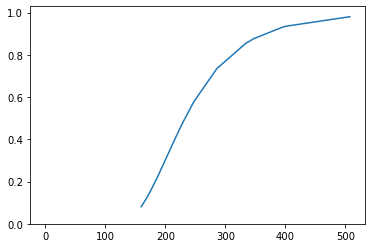

In [49]:
# 0 라벨 Distance 추출 Weibull 극단 분포 CDF
(loc0, scale0) = s.exponweib.fit_loc_scale(maxdist0, 1, 1)
print(loc0, scale0)

plt.plot(maxdist0, s.exponweib.cdf(maxdist0, *s.exponweib.fit(maxdist0, 1, 1, scale=2, loc=0)))
_ = plt.hist(maxdist0, bins=np.linspace(0, 16, len(maxdist0)), alpha=0.5);
plt.show()

102.14688228141148 51.77533316033724


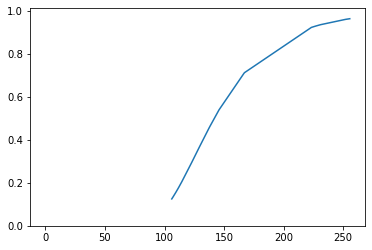

In [50]:
# 1 라벨 Distance 추출 Weibull 극단 분포 CDF
(loc1, scale1) = s.exponweib.fit_loc_scale(maxdist1, 1, 1)
print(loc1, scale1)

plt.plot(maxdist1, s.exponweib.cdf(maxdist1, *s.exponweib.fit(maxdist1, 1, 1, scale=2, loc=0)))
_ = plt.hist(maxdist1, bins=np.linspace(0, 16, len(maxdist1)), alpha=0.5);
plt.show()

239.68645911731835 55.18183017418601


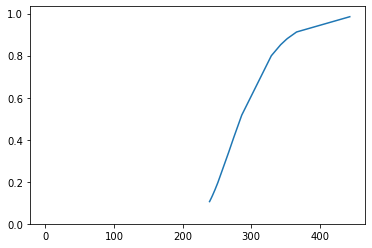

In [51]:
## 2 라벨 Distance 추출 Weibull 극단 분포 CDF
(loc2, scale2) = s.exponweib.fit_loc_scale(maxdist2, 1, 1)
print(loc2, scale2)

plt.plot(maxdist2, s.exponweib.cdf(maxdist2, *s.exponweib.fit(maxdist2, 1, 1, scale=2, loc=0)))
_ = plt.hist(maxdist2, bins=np.linspace(0, 16, len(maxdist2)), alpha=0.5);
plt.show()

## Softmax Layer 통과

In [53]:
model2 = Sequential()
model2.add(Dense(num_of_class + 1, activation = 'softmax'))
model2.compile(optimizer='adam', loss='sparse_categorical_crossentropy',metrics= ["accuracy",f1,precision, recall])

In [54]:
model2.fit(X_result, y_test, batch_size = 16)

66/66 [==============================] - 2s 2ms/step - loss: 1.8040 - accuracy: 0.3409 - f1: 1.0057 - precision: 1.0130 - recall: 1.0391


In [55]:
model2.predict(X_result, batch_size = 16)

array([[8.8974652e-05, 6.5161836e-01, 3.0545500e-01, 4.2837724e-02],
       [3.5189140e-01, 4.3111149e-02, 3.2671422e-01, 2.7828321e-01],
       [3.4036140e-07, 8.0878830e-01, 1.8343616e-01, 7.7752224e-03],
       ...,
       [9.1939114e-02, 1.5468435e-01, 4.8140925e-01, 2.7196735e-01],
       [1.3791328e-10, 8.8823783e-01, 1.1088270e-01, 8.7949005e-04],
       [9.7562283e-01, 1.2897407e-02, 2.3644930e-03, 9.1152806e-03]],
      dtype=float32)

## 결과 확인

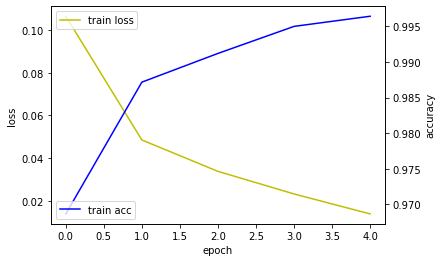

In [56]:
#모델 학습 과정 표시

fig, loss_ax = plt.subplots()

acc_ax = loss_ax.twinx()

loss_ax.plot(hist.history['loss'], 'y', label='train loss')

acc_ax.plot(hist.history['accuracy'], 'b', label='train acc')


loss_ax.set_xlabel('epoch')
loss_ax.set_ylabel('loss')
acc_ax.set_ylabel('accuracy')

loss_ax.legend(loc='upper left')
acc_ax.legend(loc='lower left')

plt.show()

In [57]:
result = pd.DataFrame(model.predict(X_test, batch_size=16),columns=['0', '1', '2'])
result["Test Label"] = y_test
result["Classification Result"] = class_result
result["Final Result"] = (y_test == class_result)

result.to_csv("test_result.csv")

In [58]:
print("테스트 정확도: %.4f" % (model.evaluate(X_test, y_test)[1]))

33/33 [==============================] - 1s 8ms/step - loss: 0.8382 - accuracy: 0.7436 - f1: 0.8278 - precision: 0.6529 - recall: 1.1477
테스트 정확도: 0.7436


## 모델 저장

In [59]:
##모델을 .json 파일 형식으로 save하여 저장
model_json = model.to_json()
with open("model.json", "w") as json_file : 
    json_file.write(model_json)
    
model.save_weights("model_weight.h5")
model.save('full_model.h5')